In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns

### Loading / Preprocessing Data

In [2]:
# Read in data from github
github_url_2010s_data = "https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-points-2010s.csv"
github_url_2020s_data = "https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-points-2020s.csv"
github_url_match_data = "https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/refs/heads/master/charting-w-matches.csv"

df_2010s = pd.read_csv(github_url_2010s_data)
df_2020s = pd.read_csv(github_url_2020s_data)
df_matches = pd.read_csv(github_url_match_data)
df = pd.concat([df_2010s, df_2020s], axis=0)
df = pd.merge(df, df_matches, on='match_id', sort="date")
df = df[df['Date'] >= '2015']
# Remove time, court, umpire, charted by columns
df = df.drop(['Time', 'Court', 'Umpire', 'Charted by', 'Notes', 'Final TB?'], axis=1)

In [3]:
df.columns

Index(['match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', 'Gm#', 'TbSet',
       'Svr', '1st', '2nd', 'PtWinner', 'Player 1', 'Player 2', 'Pl 1 hand',
       'Pl 2 hand', 'Date', 'Tournament', 'Round', 'Surface', 'Best of'],
      dtype='object')

In [4]:
df

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,Svr,...,PtWinner,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Date,Tournament,Round,Surface,Best of
43156,20150105-W-Auckland-R32-Daniela_Hantuchova-Sar...,1,0,0,0,0,0-0,1.0,True,1,...,1,Daniela Hantuchova,Sara Errani,R,R,20150105,Auckland,R32,Hard,3
43157,20150105-W-Auckland-R32-Daniela_Hantuchova-Sar...,2,0,0,0,0,15-0,1.0,True,1,...,2,Daniela Hantuchova,Sara Errani,R,R,20150105,Auckland,R32,Hard,3
43158,20150105-W-Auckland-R32-Daniela_Hantuchova-Sar...,3,0,0,0,0,15-15,1.0,True,1,...,1,Daniela Hantuchova,Sara Errani,R,R,20150105,Auckland,R32,Hard,3
43159,20150105-W-Auckland-R32-Daniela_Hantuchova-Sar...,4,0,0,0,0,30-15,1.0,True,1,...,2,Daniela Hantuchova,Sara Errani,R,R,20150105,Auckland,R32,Hard,3
43160,20150105-W-Auckland-R32-Daniela_Hantuchova-Sar...,5,0,0,0,0,30-30,1.0,True,1,...,2,Daniela Hantuchova,Sara Errani,R,R,20150105,Auckland,R32,Hard,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393875,20241011-W-Wuhan-QF-Magda_Linette-Coco_Gauff,115,0,1,4,5,15-30,16.0,True,2,...,2,Magda Linette,Coco Gauff,R,R,20241011,Wuhan,QF,Hard,3
393876,20241011-W-Wuhan-QF-Magda_Linette-Coco_Gauff,116,0,1,4,5,30-30,16.0,True,2,...,1,Magda Linette,Coco Gauff,R,R,20241011,Wuhan,QF,Hard,3
393877,20241011-W-Wuhan-QF-Magda_Linette-Coco_Gauff,117,0,1,4,5,30-40,16.0,True,2,...,2,Magda Linette,Coco Gauff,R,R,20241011,Wuhan,QF,Hard,3
393878,20241011-W-Wuhan-QF-Magda_Linette-Coco_Gauff,118,0,1,4,5,40-40,16.0,True,2,...,2,Magda Linette,Coco Gauff,R,R,20241011,Wuhan,QF,Hard,3


In [5]:
print(df['Round'].unique())

# Get rid of the rounds RR (Round robin), PO (Preliminary), BR (Bronze round), and Unipol Arena (incorrect)
df = df[df['Round'] != 'RR']
df = df[df['Round'] != 'Sir Chris Hoy Velodrome']
df = df[df['Round'] != '1']
df = df[df['Round'] != 'Emirates Arena Glasgow']
df = df[df['Round'] != 'Emirates Arena']
df = df[df['Round'] != 'Boulogne sur Mer']
df = df.dropna(subset=['Round'])
print(df['Round'].unique())


['R32' 'R16' 'QF' 'SF' 'R128' 'R64' 'F' 'RR' 'Q3' 'Q1' 'Q2' 'BR'
 'Emirates Arena' 'Sir Chris Hoy Velodrome' '1' 'Emirates Arena Glasgow'
 'Boulogne sur Mer' nan]
['R32' 'R16' 'QF' 'SF' 'R128' 'R64' 'F' 'Q3' 'Q1' 'Q2' 'BR']


In [6]:
# Find all match_ids where the points are charted incorrectly, missing points, etc.

next_point_dict = {
    "0-0": ["0-15", "15-0", "1-0", "0-1"],
    "0-15": ["0-30", "15-15"],
    "0-30": ["0-40", "15-30"],
    "0-40": ["15-40", "0-0"],
    "15-0": ["15-15", "30-0"],
    "15-15": ["15-30", "30-15"],
    "15-30": ["15-40", "30-30"],
    "15-40": ["30-40", "0-0"],
    "30-0": ["30-15", "40-0"],
    "30-15": ["30-30", "40-15"],
    "30-30": ["30-40", "40-30"],
    "30-40": ["40-40", "0-0"],
    "40-0": ["40-15", "0-0"],
    "40-15": ["40-30", "0-0"],
    "40-30": ["40-40", "0-0"],
    "40-40": ["AD-40", "40-AD", "0-0"],
    "AD-40": ["40-40", "0-0"],
    "40-AD": ["40-40", "0-0"]
}

def check_tiebreak(pt1, pt2):
    pt1, pt2 = pt1.strip(), pt2.strip()
    pt1 = pt1.split("-")
    pt2 = pt2.split("-")
    # convert to int
    pt1 = [int(x) for x in pt1]
    pt2 = [int(x) for x in pt2]
    if sum(pt1) % 2 == 0:
        return pt2 == [pt1[1]+1, pt1[0]] or pt2 == [pt1[1], pt1[0]+1] or pt2 == [0, 0]
    else:
        return pt2 == [pt1[0], pt1[1]+1] or pt2 == [pt1[0]+1, pt1[1]] or pt2 == [0, 0]

def find_matches_charted_incorrectly(df):
    incorrect_matches = []
    for match_id in df['match_id'].unique():
        df_match = df[df['match_id'] == match_id].sort_values('Pt')
        for i in range(df_match.shape[0] - 1):
            pt1 = df_match.iloc[i]['Pts']
            pt2 = df_match.iloc[i+1]['Pts']
            if (pt1 in next_point_dict and pt2 not in next_point_dict[pt1]) or (pt1 not in next_point_dict and not check_tiebreak(pt1, pt2)):
                incorrect_matches.append(match_id)
                break
            if df_match.iloc[i]['Pt'] != df_match.iloc[i+1]['Pt'] - 1:
                incorrect_matches.append(match_id)
                break
    return incorrect_matches

# Remove the matches that are charted incorrectly
incorrect_matches = find_matches_charted_incorrectly(df)
print(len(incorrect_matches), incorrect_matches)
df = df[~df['match_id'].isin(incorrect_matches)]

4 ['20200114-W-Australian_Open-Q1-Rebecca_Sramkova-Maddison_Inglis', '20220112-W-Australian_Open-Q2-Indy_De_Vroome-Dalma_Galfi', '20230707-W-Wimbledon-R32-Lesia_Tsurenko-Ana_Bogdan', '20240118-W-Australian_Open-R64-Elena_Rybakina-Anna_Blinkova']


In [48]:
# See how many matches are from the top tournaments
aus_open_matches = df[df['match_id'].str.contains('Australian_Open')]['match_id'].nunique()
us_open_matches = df[df['match_id'].str.contains('US_Open')]['match_id'].nunique()
french_open_matches = df[df['match_id'].str.contains('Roland_Garros')]['match_id'].nunique()
wimbledon_matches = df[df['match_id'].str.contains('Wimbledon')]['match_id'].nunique()

masters = ['Indian_Wells', 'Miami', 'Madrid_Masters', 'Rome',
           'Canada', 'Cincinnati', 'Beijing', 'Rome', 
           'Doha']

masters_matches = df[df['match_id'].str.contains('|'.join(masters))]['match_id'].nunique()

(aus_open_matches + us_open_matches + french_open_matches + wimbledon_matches) / df['match_id'].nunique()

0.34339141521461963

In [7]:
# Print number of unique values in the match_id, Player 1, Player 2, columns
print("Number of unique values in the match_id, Player 1, Player 2 columns:")
print(df[['match_id', 'Player 1', 'Player 2']].nunique())

Number of unique values in the match_id, Player 1, Player 2 columns:
match_id    2353
Player 1     359
Player 2     374
dtype: int64


In [8]:
# Count number of matches per player, where player can be either player 1 or player 2

players = set(df['Player 1'].unique().tolist() + df['Player 2'].unique().tolist())
player_match_counts_1 = df.groupby('Player 1')['match_id'].unique()
player_match_counts_2 = df.groupby('Player 2')['match_id'].unique()

for player in players:
    if player in player_match_counts_1:
        # assert that the matches in player_match_counts_1 and player_match_counts_2 are NOT the same for each player
        if player in player_match_counts_2:
            for match in player_match_counts_1[player]:
                assert match not in player_match_counts_2[player]

In [9]:
# To find match_point_counts get the max value of Pt for each match_id
match_point_counts = df.groupby('match_id')['Pt'].max().reset_index()

In [10]:
# Get number of poitns per match
match_point_counts = df.groupby('match_id')['Pt'].max().reset_index()

# Create series of match_ids for Player 1 and Player 2
player_match_counts_1 = df.groupby('Player 1')['match_id'].apply(list)
player_match_counts_2 = df.groupby('Player 2')['match_id'].apply(list)

# Rename index and convert to DataFrame
df1 = player_match_counts_1.rename_axis('player').reset_index(name='match_ids')
df2 = player_match_counts_2.rename_axis('player').reset_index(name='match_ids')

# Combine the two DataFrames
combined = pd.concat([df1, df2], ignore_index=True)

# Group by player and concatenate match_id lists
player_matches = combined.groupby('player')['match_ids'].agg(lambda lists: list(np.unique(sum(lists, [])))).reset_index()

# Add a column with number of points per player
player_matches['num_points'] = player_matches['match_ids'].apply(lambda x: sum(match_point_counts[match_point_counts['match_id'].isin(x)]['Pt']))

player_matches

,player,match_ids,num_points
0,Agnieszka Radwanska,[20150113-W-Sydney-R16-Agnieszka_Radwanska-Gar...,3293
1,Ajla Tomljanovic,[20170529-W-Roland_Garros-R128-Kiki_Bertens-Aj...,2491
2,Alba Carrillo Marin,[20210128-W-ITF_Manacor-R16-Alba_Carrillo_Mari...,98
3,Aleksandra Krunic,[20150616-W-Birmingham-R64-Aleksandra_Krunic-H...,730
4,Alexa Noel,[20240827-W-US_Open-R128-Alexa_Noel-Sara_Sorri...,103
...,...,...,...
485,Yuriko Miyazaki,[20220607-W-Nottingham-R32-Magdalena_Frech-Yur...,280
486,Yuxuan Zhang,[20190801-W-ITF_Lexington-R16-Katie_Swan-Yuxua...,78
487,Zarina Diyas,[20150115-W-Hobart-QF-Zarina_Diyas-Alison_Risk...,606
488,Zeynep Sonmez,[20230613-W-s_Hertogenbosch-R32-Zeynep_Sonmez-...,124


In [11]:
# Count how many players have 0-100 points, 100-1000 points, 1000-5000 points, 5000-10000 points, and 10000+ points
player_matches['num_points'].value_counts()
bins = [0, 100, 1000, 5000, 10000, float('inf')]
labels = ['0-100', '100-1000', '1000-5000', '5000-10000', '10000+']
pd.cut(player_matches['num_points'], bins=bins, labels=labels).value_counts()

100-1000      298
1000-5000     121
0-100          38
5000-10000     26
10000+          7
Name: num_points, dtype: int64

In [12]:
df_wta_players = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/refs/heads/master/wta_players.csv")
df_rankings_2010s = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/refs/heads/master/wta_rankings_10s.csv")
df_rankings_2020s = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/refs/heads/master/wta_rankings_20s.csv")
df_rankings_current = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_wta/refs/heads/master/wta_rankings_current.csv")
# concat all rankings dfs
df_rankings = pd.concat([df_rankings_2010s, df_rankings_2020s, df_rankings_current], axis=0)
# rename player to player_id
df_rankings = df_rankings.rename(columns={'player': 'player_id'})
df_rankings = pd.merge(df_rankings, df_wta_players, on='player_id', sort='ranking_date')
# create a column player that is the concatenation of name_first and name_last
df_rankings['player'] = df_rankings['name_first'] + " " + df_rankings['name_last']
# average rank by player
df_average_rank = df_rankings.groupby(['player'])['rank'].min().reset_index()

/Users/anika/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
player_matches_and_rank = pd.merge(player_matches, df_average_rank, how='inner', on='player')
player_matches_and_rank['num_matches'] = player_matches_and_rank['match_ids'].apply(lambda x: len(x))
player_matches_and_rank

,player,match_ids,num_points,rank,num_matches
0,Agnieszka Radwanska,[20150113-W-Sydney-R16-Agnieszka_Radwanska-Gar...,3293,2,23
1,Ajla Tomljanovic,[20170529-W-Roland_Garros-R128-Kiki_Bertens-Aj...,2491,32,18
2,Alba Carrillo Marin,[20210128-W-ITF_Manacor-R16-Alba_Carrillo_Mari...,98,490,1
3,Aleksandra Krunic,[20150616-W-Birmingham-R64-Aleksandra_Krunic-H...,730,39,6
4,Alexa Noel,[20240827-W-US_Open-R128-Alexa_Noel-Sara_Sorri...,103,679,1
...,...,...,...,...,...
484,Yuriko Miyazaki,[20220607-W-Nottingham-R32-Magdalena_Frech-Yur...,280,132,2
485,Yuxuan Zhang,[20190801-W-ITF_Lexington-R16-Katie_Swan-Yuxua...,78,166,1
486,Zarina Diyas,[20150115-W-Hobart-QF-Zarina_Diyas-Alison_Risk...,606,31,6
487,Zeynep Sonmez,[20230613-W-s_Hertogenbosch-R32-Zeynep_Sonmez-...,124,88,1


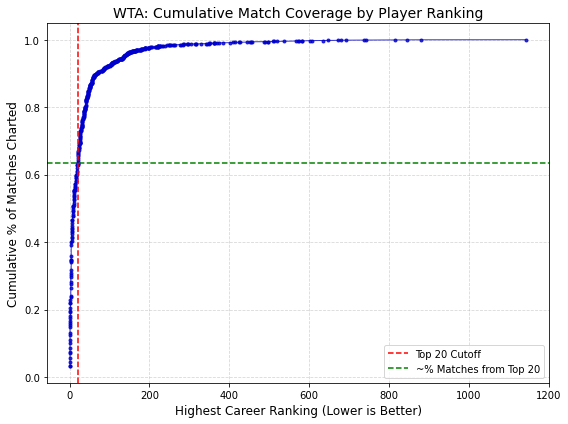

In [49]:
df_sorted = player_matches_and_rank.sort_values(by='rank')
df_sorted['cumulative_matches'] = df_sorted['num_matches'].cumsum()
df_sorted['cumulative_pct'] = df_sorted['cumulative_matches'] / df_sorted['num_matches'].sum()

plt.figure(figsize=(8, 6))
plt.plot(df_sorted['rank'], df_sorted['cumulative_pct'], marker='o', color='mediumblue', alpha=0.8, linewidth=1, markersize=3)
plt.axvline(x=20, color='red', linestyle='--', label='Top 20 Cutoff')
plt.axhline(y=df_sorted[df_sorted['rank'] <= 20]['cumulative_pct'].max(), color='green', linestyle='--', label='~% Matches from Top 20')
plt.xlabel('Highest Career Ranking (Lower is Better)', fontsize=12)
plt.ylabel('Cumulative % of Matches Charted', fontsize=12)
plt.title('WTA: Cumulative Match Coverage by Player Ranking', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

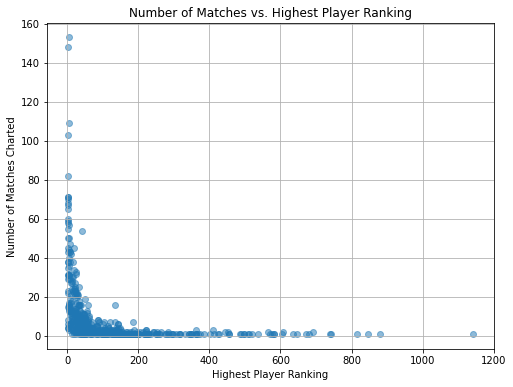

In [15]:
# Visualization: Number of Matches vs. Average Player Rank
plt.figure(figsize=(8, 6))
plt.scatter(player_matches_and_rank['rank'], player_matches_and_rank['num_matches'], alpha=0.5)
plt.xlabel('Highest Player Ranking')
plt.ylabel('Number of Matches Charted')
plt.title('Number of Matches vs. Highest Player Ranking')
plt.grid(True)
plt.show()


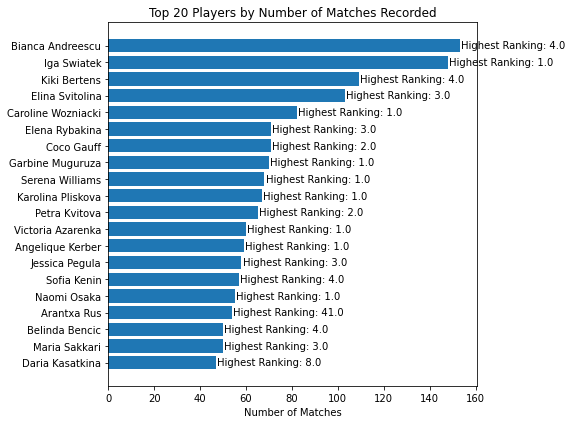

In [17]:
# Visualization: Top 30 Players by Number of Matches Charted
top_players = player_matches_and_rank.sort_values(by='num_matches', ascending=False).head(20)

plt.figure(figsize=(8, 6))
bars = plt.barh(top_players['player'], top_players['num_matches'])
plt.xlabel('Number of Matches')
plt.title('Top 20 Players by Number of Matches Recorded')
plt.gca().invert_yaxis()  # Highest first

# Add average rank labels next to each bar
for bar, rank in zip(bars, top_players['rank']):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'Highest Ranking: {int(rank):.1f}', va='center')

plt.tight_layout()
plt.show()

In [24]:
# List all players with at least 15 matches charted
players_15_matches = player_matches_and_rank[player_matches_and_rank['num_matches'] >= 15]['player'].values
# Count match_ids in df where both player 1 and player 2 are in players_15_matches
matches_15_players = df[df['Player 1'].isin(players_15_matches) & df['Player 2'].isin(players_15_matches)]
# # Count unique matches
# matches_15_players = matches_15_players['match_id'].unique()
# print("Number of matches between players with at least 15 matches:", len(matches_15_players))

### Serve + 1 Data Analysis

In [18]:
def decode_rally(code_str, server):
    translation_table = str.maketrans('', '', '!+c;-=^ ')
    code_str = code_str.translate(translation_table)

    shots = []

    shot = {
        'player': server,
        'shot': None,
        'location': None,
        'depth': None,
        'error': None,
        'error_type': None,
        'unreturnable': False
    }

    location_map = {
        '1': 'deuce court',
        '2': 'middle',
        '3': 'ad court',
        '4': 'wide',   # wide serve
        '5': 'body',       # body serve
        '6': 'T',  # down the T
        '7': 'short',
        '8': 'middle',
        '9': 'deep',
        '0': 'unknown'
    }

    error_loc_map = {
        'n': 'net', 'w': 'wide', 'd': 'deep', 'x': 'wide and deep',
        '!': 'shank', 'e': 'unknown', 'g': 'foot fault', 'V': 'time violation'
    }

    shot_map = {
        'f': 'forehand', 'b': 'backhand', 'r': 'forehand slice', 's': 'backhand slice',
        'v': 'forehand volley', 'z': 'backhand volley', 'o': 'overhead', 'p': 'backhand overhead',
        'u': 'forehand drop shot', 'y': 'backhand drop shot', 'l': 'forehand lob',
        'm': 'backhand lob', 'h': 'forehand half-volley', 'i': 'backhand half-volley',
        'j': 'forehand swinging volley', 'k': 'backhand swinging volley',
        't': 'trick shot', 'q': 'unknown shot'
    }

    pattern_serve = re.compile(r'([SR0456]?)([nwdx!egV]?)([nwdx!egV]?)([*#@C]?)')
    match = pattern_serve.match(code_str)
    i = 0
    if match:
        shot['shot'] = 'serve'
        shot['location'] = location_map.get(match.group(1), None)
        shot['unreturnable'] = bool(match.group(4))
        shot['error'] = error_loc_map.get(match.group(2), None)
        i += len(match.group(0))
        shots.append(shot)
    else:
        print(f'No match serve for {code_str}')
        return None

    pattern_rally = re.compile(r'([fbrsvzopuylmhijktq])([0-9]?)([0-9]?)([0-9]?)([nwdx!egV]?)([nwdx!egV]?)([@*#C]?)')
    while i < len(code_str):

        shot = {
            'player': 1 if shots[-1]['player'] == 2 else 2,
            'shot': None,
            'location': None,
            'depth': None,
            'error': None,
            'error_type': None,
            'unreturnable': False
        }
        
        match = pattern_rally.match(code_str[i:])

        if match:
            shot['shot'] = shot_map.get(match.group(1), None)
            shot['location'] = location_map.get(match.group(2), None)
            shot['depth'] = location_map.get(match.group(3), None)
            shot['error'] = error_loc_map.get(match.group(5), None)
            if match.group(7) == '@':
                shot['error_type'] = 'unforced'
            elif match.group(7) == '#':
                shot['error_type'] = 'forced'
            elif match.group(7) == 'C':
                shot['error_type'] = 'challenge'
            elif match.group(7) == '*':
                shot['unreturnable'] = True    
            i += len(match.group(0))
            shots.append(shot)

        else:
            print(f'No match rally for {i, code_str}')
            return None

    return shots


In [19]:
def get_point_side(score):
    # Score is in the form '1-0' (Tiebreak) or '30-40' (Game)
    # Returns 'ad' for advantage, 'deuce' for deuce
    game_to_pts = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}

    if score in next_point_dict: # Game score
        pts1 = game_to_pts[score.split('-')[0]]
        pts2 = game_to_pts[score.split('-')[1]]
    else: # Tiebreak score
        pts1 = int(score.split('-')[0])
        pts2 = int(score.split('-')[1])
    
    if (pts1 + pts2) % 2 == 0:
        return 'deuce'
    return 'ad'

assert get_point_side('0-0') == 'deuce'
assert get_point_side('30-40') == 'ad'
assert get_point_side('1-0') == 'ad'
assert get_point_side('1-1') == 'deuce'
assert get_point_side('40-AD') == 'ad'
assert get_point_side('40-40') == 'deuce'
assert get_point_side('15-0') == 'ad'
assert get_point_side('10-9') == 'ad'
assert get_point_side('6-0') == 'deuce'

In [20]:
def get_rally_length(row):
    # Returns the length of the rally
    first = row['1st']
    second = row['2nd']
    seq = first
    winner = row['pt_winner']

    if second:
        seq = second

    if seq and seq[-1]['player'] == winner:
        return len(seq)
    
    return len(seq) - 1 if seq else 0


def get_error(row):
    first = row['1st']
    second = row['2nd']
    seq = first
    winner = row['pt_winner']

    if second:
        seq = second

    if seq and seq[-1]['player'] == winner:
        return 'forced'
    
    if seq and seq[-1]['player'] != winner:
        return seq[-1]['error_type'] if seq[-1]['error_type'] is not None or seq[-1]['error_type'] == 'challenge' else 'unforced'
    
    return 'unforced'

In [21]:
def get_rally_info(df):
    # Create a list to store the info for each rally
    rally_info_list = []

    print('Length of df:', df.shape[0])

    for i in range(df.shape[0]):
        if i % 10000 == 0:
            print(i)

        try:

            first_serve = decode_rally(df.iloc[i]['1st'], df.iloc[i]['Svr']) if pd.notna(df.iloc[i]['1st']) else None
            second_serve = decode_rally(df.iloc[i]['2nd'], df.iloc[i]['Svr']) if pd.notna(df.iloc[i]['2nd']) else None
            
            info = {
                'match_id': df.iloc[i]['match_id'],
                'player1': df.iloc[i]['Player 1'],
                'player2': df.iloc[i]['Player 2'],
                'server': df.iloc[i]['Svr'],
                'pt_number': df.iloc[i]['Pt'],
                'game_score': df.iloc[i]['Pts'],
                'side': get_point_side(df.iloc[i]['Pts']),
                'game_number': df.iloc[i]['Gm#'],
                'player1_sets': df.iloc[i]['Set1'],
                'player2_sets': df.iloc[i]['Set2'],
                'player1_games_in_set': df.iloc[i]['Gm1'],
                'player2_games_in_set': df.iloc[i]['Gm2'],
                '1st': first_serve,
                '2nd': second_serve,
                'pt_winner': df.iloc[i]['PtWinner'],
            }
            rally_info_list.append(info)
        
        except Exception as e:
            print(f'Error at {i}: {e}')

    # Convert the list of dictionaries to a DataFrame
    output = pd.DataFrame(rally_info_list)

    # Add the rally length and error type
    output['rally_length'] = output.apply(get_rally_length, axis=1)

    output['error_type'] = output.apply(get_error, axis=1)

    # Convert the pt_number, game_number, player1_sets, player2_sets, player1_games_in_set, player2_games_in_set columns to int
    output['pt_number'] = output['pt_number'].fillna(-1).astype(int)
    output['game_number'] = output['game_number'].fillna(-1).astype(int)
    output['player1_sets'] = output['player1_sets'].fillna(-1).astype(int)
    output['player2_sets'] = output['player2_sets'].fillna(-1).astype(int)
    output['player1_games_in_set'] = output['player1_games_in_set'].fillna(-1).astype(int)
    output['player2_games_in_set'] = output['player2_games_in_set'].fillna(-1).astype(int)

    # Count all rows where there 1st AND 2nd are both NaN
    if output[(output['1st'].isna() & output['2nd'].isna())].shape[0] > 0:
        # Delete rows where there 1st AND 2nd are both NaN
        output = output[~(output['1st'].isna() & output['2nd'].isna())]

    return output

In [22]:
# Get the info for all rallies and save to a df
all_rally_info = get_rally_info(df)

Length of df: 332791
0
No match rally for (0, 'Q')
No match rally for (0, 'Q')
No match rally for (0, 'P')
No match rally for (0, 'P')
No match rally for (0, 'Q')
10000
No match rally for (0, 'Q')
20000
No match rally for (0, 'Q')
30000
No match rally for (11, '5b39b1f3b3d2')
No match rally for (3, '4b#n')
40000
No match rally for (7, 'SuesfulTsurenkoChallenge/PointReplayed')
50000
No match rally for (13, '4f28b2b3b3b1#w')
No match rally for (14, '5f29f1b1f3l2v@1*')
No match rally for (0, '9*')
No match rally for (0, '1b2f1f1f2b3w@')
No match rally for (12, '6f3b2b3b2f1*@')
No match rally for (7, '5b2b1w#@')
60000
No match rally for (0, '3b28f3b3b1f2f2f3*')
No match rally for (10, '5b38b2y1fn1#')
No match rally for (0, 'Q')
No match rally for (0, 'Q')
No match rally for (0, 'Q')
No match rally for (0, 'Q')
No match rally for (0, 'Q')
No match rally for (8, '6fbbbff@n')
No match rally for (6, '5ffff@n')
No match rally for (4, '5fb@d')
No match rally for (3, '5f@n')
No match rally for (3

In [24]:
unique_matches = all_rally_info['match_id'].unique()
num_points = len(all_rally_info)
num_players = len(set(all_rally_info['player1'].unique()).union(set(all_rally_info['player2'].unique())))
print(f'Number of unique matches: {len(unique_matches)}')
print(f'Number of rallies: {num_points}')
print(f'Number of players: {num_players}')

Number of unique matches: 2353
Number of rallies: 332480
Number of players: 490


In [25]:
all_rally_info.to_csv('generated_datasets/wta_all_rally_info.csv', index=False)

In [30]:
players_5_matches = player_matches_and_rank[player_matches_and_rank['num_matches'] >= 5]['player'].values
five_players_info = all_rally_info[all_rally_info['player1'].isin(players_5_matches) | all_rally_info['player2'].isin(players_5_matches)]
five_players_info.to_csv('generated_datasets/wta_rally_info_players_with_5+_matches.csv', index=False)

In [32]:
def extract_serve_plus1(row):
    shots = row['1st'] if row['1st'] else []
    if not shots or (shots and shots[0].get('error')):  # fault
        shots = row['2nd'] if row['2nd'] else []

    if not shots:
        return pd.Series({
            'combo': None,
            'server': None,
            'won': None
        })

    server = shots[0]['player']
    loc = shots[0].get('location')
    if loc is None:
        loc = 'unknown'

    serve_shot = 'serve ' + loc

    plus1_shot = None
    plus1_loc = None

    for shot in shots[1:]:
        if shot['player'] == server:
            plus1_shot = shot.get('shot', 'unknown')
            plus1_loc = shot.get('location')
            break

    if plus1_shot:
        combo = f"{serve_shot} + {plus1_shot} to {plus1_loc}"
    else:
        combo = None

    winner = row.get('pt_winner')
    server_won = (winner == server)

    rally_length = row.get('rally_length')
    error_type = row.get('error_type')

    return pd.Series({
        'combo': combo,
        'server': server,
        'won': server_won,
        'rally_length': rally_length,
        'error_type': error_type
    })

def get_serve_plus1_stats(df):

    def get_stats(df):
        combo_df = df.apply(extract_serve_plus1, axis=1).dropna(subset=['combo'])
        combo_df['won'] = combo_df['won'].astype(bool)

        # Drop any rows where there is an unknown in combo
        combo_df = combo_df[~combo_df['combo'].str.contains('unknown')]

        # Store rally lengths as a list for each combo
        rally_lengths = (
            combo_df.groupby('combo')['rally_length']
            .apply(list)
            .reset_index(name='rally_lengths')
        )

        error_summary = (
            combo_df[combo_df['won']]
            .groupby(['combo', 'error_type'])
            .size()
            .unstack(fill_value=0)
            .reset_index()
        )

        if 'unforced' not in error_summary.columns:
            error_summary['unforced'] = 0

        summary = (
            combo_df
            .groupby('combo')
            .agg(
                count=('won', 'count'),
                win_pct=('won', 'mean'),
                median_rally=('rally_length', 'median'),
                mean_rally=('rally_length', 'mean'),
                min_rally=('rally_length', 'min'),
                max_rally=('rally_length', 'max')
            )
            .reset_index()
            .merge(rally_lengths, on='combo')  # Attach raw rally lengths
            .merge(error_summary, on='combo', how='left')  # Attach error frequencies
        )

        if 'unforced' not in summary.columns:
            print(summary.columns)
            print(summary)

        summary = summary.fillna(0)

        summary['freq_pct'] = summary['count'] / summary['count'].sum()
        summary[['serve_location', 'plus_one']] = summary['combo'].str.split('+', expand=True)
        summary['total_pts_won'] = summary.get('unforced', 0) + summary.get('forced', 0)

        summary['pct_forced_generated'] = summary.apply(
            lambda row: row['forced'] / row['total_pts_won'] if row['total_pts_won'] > 0 else 0, axis=1
        )
        summary['pct_unforced_generated'] = summary.apply(
            lambda row: row['unforced'] / row['total_pts_won'] if row['total_pts_won'] > 0 else 0, axis=1
        )

        # make sure that all values are numeric
        summary['count'] = summary['count'].astype(int)
        summary['win_pct'] = summary['win_pct'].astype(float)
        summary['median_rally'] = summary['median_rally'].astype(int)
        summary['mean_rally'] = summary['mean_rally'].astype(int)
        summary['min_rally'] = summary['min_rally'].astype(int)
        summary['max_rally'] = summary['max_rally'].astype(int)
        summary['freq_pct'] = summary['freq_pct'].astype(float)
        summary['pct_forced_generated'] = summary['pct_forced_generated'].astype(float)
        summary['pct_unforced_generated'] = summary['pct_unforced_generated'].astype(float)
        
        
        return summary.sort_values('freq_pct', ascending=False)
    
    df_deuce = df[df['side'] == 'deuce']
    df_ad = df[df['side'] == 'ad']

    df_deuce_first = df_deuce[df_deuce['2nd'].isna()]
    df_ad_first = df_ad[df_ad['2nd'].isna()]

    df_deuce_second = df_deuce[df_deuce['2nd'].notna()]
    df_ad_second = df_ad[df_ad['2nd'].notna()]

    df_deuce_first_summary = get_stats(df_deuce_first)
    df_ad_first_summary = get_stats(df_ad_first)

    df_deuce_second_summary = get_stats(df_deuce_second)
    df_ad_second_summary = get_stats(df_ad_second)

    return df_deuce_first_summary, df_deuce_second_summary, df_ad_first_summary, df_ad_second_summary


In [33]:
def create_player_profile(df, player_name, court_surface = None, match_id = None, pressure_points = False):
    
    player_df = df[((df['Player 1'] == player_name) & (df['Svr'] == 1)) | ((df['Player 2'] == player_name) & (df['Svr'] == 2))]
    if court_surface:
        player_df = player_df[player_df['Surface'] == court_surface]
    if match_id:
        player_df = player_df[player_df['match_id'] == match_id]
    if pressure_points:
        player_df = player_df[player_df['pressure_point'] is True] # Not implemented yet

    df_details = get_rally_info(player_df)

    deuce_first, deuce_second, ad_first, ad_second = get_serve_plus1_stats(df_details)

    # Set style
    sns.set_style("white")
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.labelpad'] = 8
    primary_palette = ['#2E86AB', '#F18F01', '#A23B72', '#3B8EA5']
    bg_color = '#F7F7F7'

    # Create figure
    fig = plt.figure(figsize=(20, 14), facecolor=bg_color)
    gs = fig.add_gridspec(4, 4, width_ratios=[1, 1, 1.2, 1.2])

    contexts = [
        ("Deuce 1st Serve", deuce_first, gs[0, :2]),
        ("Deuce 2nd Serve", deuce_second, gs[1, :2]),
        ("Ad 1st Serve", ad_first, gs[2, :2]),
        ("Ad 2nd Serve", ad_second, gs[3, :2])
    ]

    # Create effectiveness plots
    for i, (title, df, cell) in enumerate(contexts):
        ax = fig.add_subplot(cell)
        df = df.nlargest(4, 'freq_pct')  # Top 4 patterns

        # print(df)

        # Bar plot for frequency
        bars = ax.barh(
            y=range(len(df)),
            width=df['freq_pct'] * 100,
            color=primary_palette[i],
            alpha=0.8,
            height=0.7
        )

        # Add win rate + error type labels
        for j, (_, row) in enumerate(df.iterrows()):
            win_rate = row['win_pct'] * 100
            forced_pct = row.get('pct_forced_generated', 0) * 100
            unforced_pct = row.get('pct_unforced_generated', 0) * 100

            ax.scatter(
                win_rate,
                j,
                color='gray',
                edgecolor='black',
                s=300,
                zorder=2,
                linewidth=1
            )

            ax.text(
                win_rate,
                j,
                f" {win_rate:.0f}%\nF:{forced_pct:.0f}% U:{unforced_pct:.0f}%",
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                linespacing=1.2,
                bbox=dict(
                    facecolor='white',
                    edgecolor='none',
                    pad=1,
                    alpha=0.85
                )
            )

        ax.set_yticks(range(len(df)))
        ax.set_yticklabels(
            [f"{row['serve_location'].strip()}\n+ {row['plus_one'].strip()}"
             for _, row in df.iterrows()],
            fontsize=11,
            linespacing=1.2
        )
        ax.set_xlim(0, max(df['freq_pct'].max() * 115, df['win_pct'].max() * 115))
        ax.axvline(50, color='gray', linestyle=':', alpha=0.8, linewidth=1)
        ax.set_title(title, pad=12, fontsize=12, fontweight='bold')
        ax.set_xlabel("Frequency (%) and Win %", fontsize=10)
        ax.tick_params(axis='x', labelsize=9)

        # Custom legend: add one manually on first plot
        if i == 0:
            from matplotlib.patches import Patch
            from matplotlib.lines import Line2D

            legend_elements = [
                Patch(facecolor=primary_palette[i], label='Frequency of Pattern (%)'),
                Line2D([0], [0], marker='o', color='w', label='Win % (Dot)',
                    markerfacecolor='gray', markersize=10, linewidth=0, alpha = 0.8),
                Line2D([0], [0], label='F: Forced Error %, U: Unforced Error %', color='gray', linestyle=':', linewidth=0, alpha = 0.8)
            ]
            ax.legend(handles=legend_elements, loc='center', frameon=False, fontsize=9, bbox_to_anchor=(1.15, 1.15))

    # Create rally length KDE plots
    rally_axes = [
        fig.add_subplot(gs[0, 2:]),
        fig.add_subplot(gs[1, 2:]),
        fig.add_subplot(gs[2, 2:]),
        fig.add_subplot(gs[3, 2:])
    ]

    for i, (title, df, ax) in enumerate(zip(
        ["Deuce 1st Serve", "Deuce 2nd Serve", "Ad 1st Serve", "Ad 2nd Serve"],
        [deuce_first, deuce_second, ad_first, ad_second],
        rally_axes
    )):
        df = df.nlargest(4, 'freq_pct')

        for j, (_, row) in enumerate(df.iterrows()):
            label = (f"{row['serve_location'].strip()} + {row['plus_one'].strip()}\n"
                     f"Median: {np.median(row['rally_lengths']):.1f} | "
                     f"Mean: {np.mean(row['rally_lengths']):.1f}")

            sns.kdeplot(
                row['rally_lengths'],
                ax=ax,
                color=primary_palette[j],
                label=label,
                linewidth=2.5,
                alpha=0.8,
                warn_singular=False
            )

        ax.set_xlim(0, 20)
        ax.set_title(f"{title} Rally Length Distribution", pad=12, fontsize=12, fontweight='bold')
        ax.set_xlabel("Number of Shots", fontsize=10)
        ax.set_ylabel("Density", fontsize=10)
        ax.legend(
            frameon=False,
            fontsize=9,
            loc='upper right',
            bbox_to_anchor=(1, 1),
            handlelength=1.5,
            labelspacing=0.8
        )
        ax.grid(True, alpha=0.2)
        ax.tick_params(axis='both', labelsize=9)

    title = f"{player_name} Serve + 1 Profile"
    
    if court_surface:
        title = f"{player_name} Serve + 1 Profile on {court_surface} Court"

    elif match_id:
        title = f"{player_name} Serve + 1 Profile in {match_id}"

    fig.suptitle(
        title,
        y=0.98,
        fontsize=16,
        fontweight='bold',
        color='#333333'
    )

    plt.tight_layout(pad=3)
    return fig


Length of df: 4122
0
No match rally for (0, 'P')


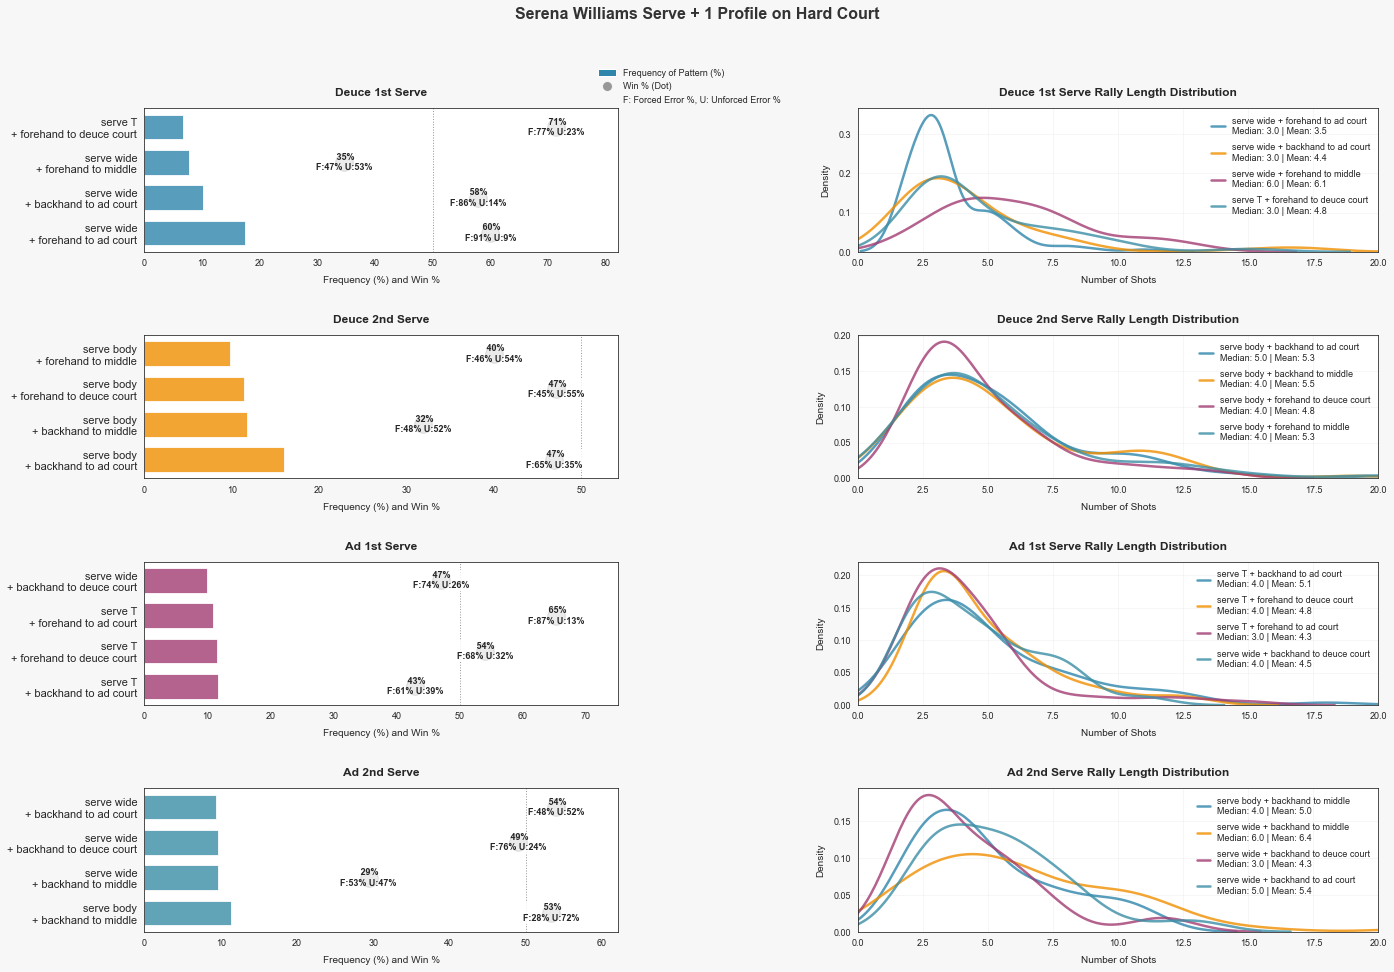

In [34]:
fig = create_player_profile(df, 'Serena Williams', 'Hard')

Length of df: 1700
0


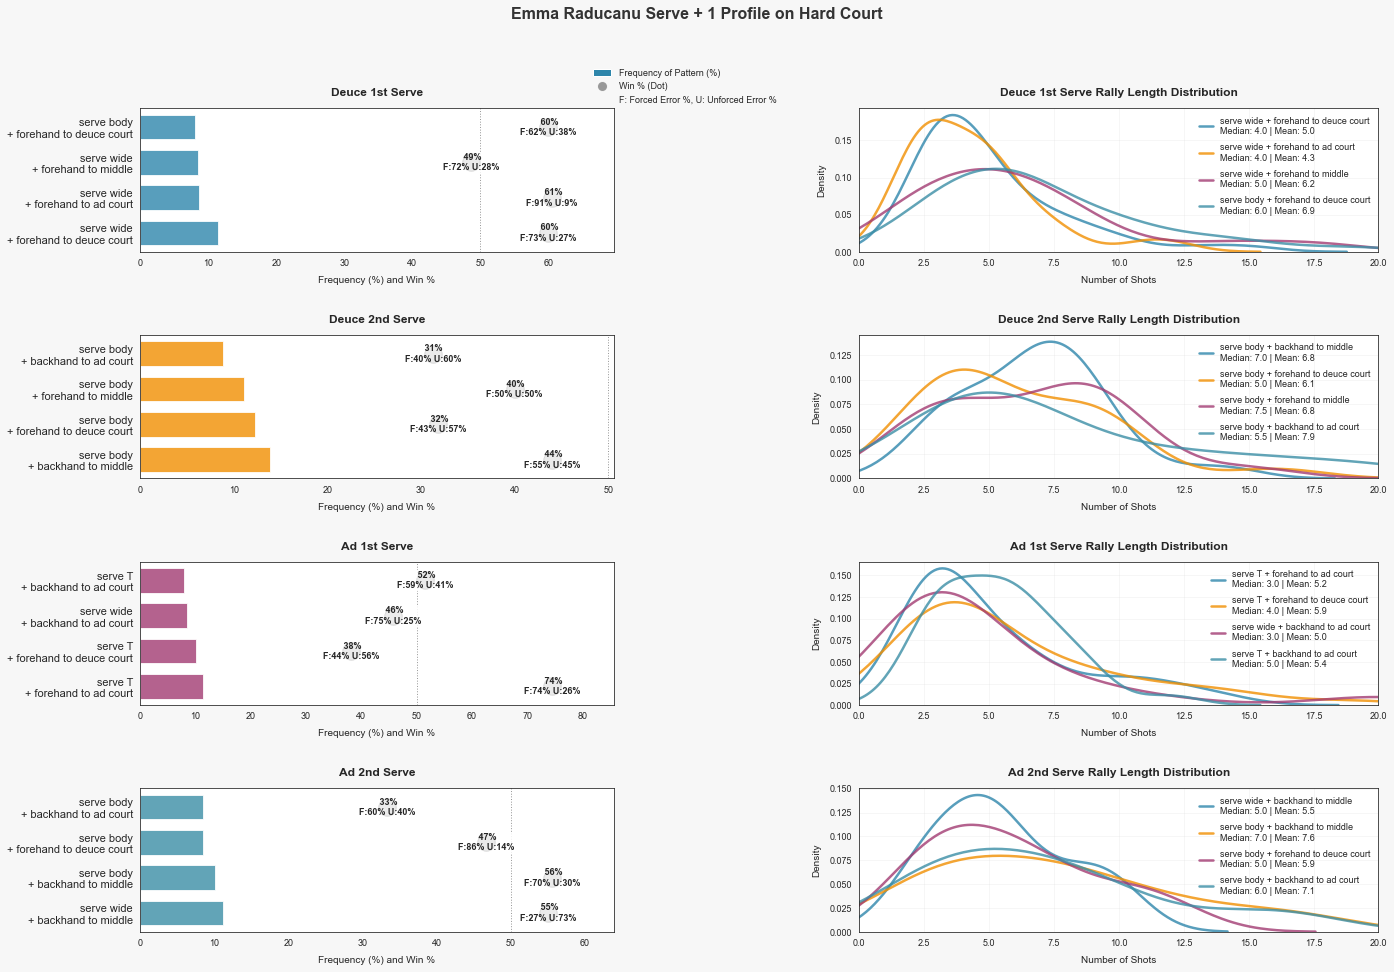

In [35]:
fig = create_player_profile(df, 'Emma Raducanu', 'Hard')